In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
from control.matlab import impulse as _impulse

def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 

# import slycot
from scipy import signal,io
import os
from scipy.linalg import fractional_matrix_power
from scipy.linalg import fractional_matrix_power as matpow
import scipy.linalg

# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})


In [2]:
def _svd(*args):
    U,S,V = scipy.linalg.svd(*args, lapack_driver="gesvd")
    return U,S,V.T.conj()

In [3]:
q = 2   # Number of inputs
p = 2   # Number of outputs
n = 100 # State dimension
r = 10 # Reduced model order
dt = 1 # Timestep

testSys_mat = io.loadmat(os.path.join('..','DATA','testSys_ABCD.mat'))
A = testSys_mat['A']
B = testSys_mat['B']
C = testSys_mat['C']
D = testSys_mat['D']

sysFull = ss(A,B,C,D,dt)

In [4]:
yFull = np.zeros((r*5+2,p,q))
tspan = np.arange(0,(r*5+2),1)
m = len(tspan)

for qi in range(q):
    yFull[:,:,qi],t = impulse(sysFull,T=tspan,input=qi)

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m
print(YY.shape)

(2, 2, 52)


In [5]:
## ERA and OKID Function Definitions

def era(Y,mo,mc,p,q,r,dt=1):
    # get D from first input_dimension columns of impulse response
    Dr = Y[:,:,0]  # first block of output data
    
    assert Y.shape[:2] == (p,q)  # sanity check that we're passing in the right output data
    assert Y.shape[2] >= mo+mc   # make sure there are enough timesteps to assemble this size of Hankel matrix
    
    # make impulse response into hankel matrix and shifted hankel matrix
    H0 = np.zeros((p*mo, q*mc))
    H1 = np.zeros((p*mo, q*mc))
    for i in range(mo):
        for j in range(mc):
            H0[p*i:p*(i+1), q*j:q*(j+1)] = Y[:,:,i+j+1]
            H1[p*i:p*(i+1), q*j:q*(j+1)] = Y[:,:,i+j+2]
    # reduced svd of hankel matrix
    U,S,V = _svd(H0)
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]

    # get A from svd and shifted hankel matrix
    Ar = matpow(Sigma,-0.5) @ Ur.T @ H1 @ Vr @ matpow(Sigma,-0.5)

    # get B and C
    Br = (matpow(Sigma,0.5) @ Vr.T)[:,:q]
    Cr = (Ur @ matpow(Sigma,0.5))[:p,:]

    # eigendecomp A
    W,R = scipy.linalg.eig(Ar)

    # get frequencies from eigendecomp of A
    omega = np.log(W + 2*np.pi*1j/dt)
    print(f"{omega=}")

    # get modeshapes from C and eigendecomp of A
    phi = Cr @ R
    print(f"{phi=}")    

    # return (Ar,Br,Cr,Dr,omega,phi)
    return (Ar,Br,Cr,Dr,S)

def ERA(YY,m,n,nin,nout,r):
    Dr = np.zeros((nout,nin))
    Y = np.zeros((nout,nin,YY.shape[2]-1))
    # for i in range(nout):
    #     for j in range(nin):
    #         Dr[i,j] = YY[i,j,0]
    #         Y[i,j,:] = YY[i,j,1:]
    
    Dr = YY[:,:,0]
    Y = YY[:,:,1:]
            
    # assert len(Y[:,0,0]) == nout
    # assert len(Y[0,:,0]) == nin
    # assert len(Y[0,0,:]) >= m+n
    
    assert Y.shape[:2] == (nout,nin)
    assert Y.shape[2] >= m+n 

    H = np.zeros((nout*m,nin*n))
    H2 = np.zeros((nout*m,nin*n))
    
    # for i in range(m):
    #     for j in range(n):
    #         for Q in range(nout):
    #             for P in range(nin):
    #                 H[nout*i+Q,nin*j+P] = Y[Q,P,i+j]
    #                 H2[nout*i+Q,nin*j+P] = Y[Q,P,i+j+1]
    for i in range(m):
        for j in range(n):
            H[nout*i:nout*(i+1), nin*j:nin*(j+1)] = Y[:,:,i+j]
            H2[nout*i:nout*(i+1), nin*j:nin*(j+1)] = Y[:,:,i+j+1]
                    
    # U,S,VT = np.linalg.svd(H,full_matrices=0)
    # V = VT.T
    U,S,V = _svd(H)
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H2 @ Vr @ fractional_matrix_power(Sigma,-0.5)
    # Br = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H[:,:nin]
    # Cr = H[:nout,:] @ Vr @ fractional_matrix_power(Sigma,-0.5)
    Br = (fractional_matrix_power(Sigma,0.5) @ Vr.T)[:,:nin]
    Cr = (Ur @ fractional_matrix_power(Sigma,0.5))[:nout,:]
    HSVs = S
    return Ar,Br,Cr,Dr,HSVs

def OKID(y,u,r):
    # inputs:  y (sampled output), u (sampled input), r (effective system order)
    # outputs: H (Markov parameters), M (Observer gain)
    
    PP = y.shape[0] # number of outputs
    MM = y.shape[1] # number of output samples
    QQ = u.shape[0] # number of inputs
    lu = u.shape[1] # number of input samples
    
    assert MM == lu
    print(MM)
    print(lu)
    
    LL = r*5
    
    # Form data matrices y and V
    V = np.zeros((QQ+(QQ+PP)*LL,MM))
    for i in range(MM):
        V[:QQ,i] = u[:QQ,i]
        
    for i in range(1,LL+1):
        for j in range(MM-i):
            vtemp = np.concatenate((u[:,j],y[:,j]))
            V[QQ+(i-1)*(QQ+PP):QQ+i*(QQ+PP),i+j] = vtemp
    
    # Solve for observer Markov parameters Ybar
    Ybar = y @ np.linalg.pinv(V,rcond=10**(-3))
    
    # Isolate system Markov parameters H, and observer gain M
    D = Ybar[:,:QQ] # feed-through term (or D matrix) is the first term
    
    Y = np.zeros((PP,QQ,LL))
    Ybar1 = np.zeros((PP,QQ,LL))
    Ybar2 = np.zeros((PP,QQ,LL))
    
    for i in range(LL):
        Ybar1[:,:,i] = Ybar[:,QQ+(QQ+PP)*i : QQ+(QQ+PP)*i+QQ]
        Ybar2[:,:,i] = Ybar[:,QQ+(QQ+PP)*i+QQ : QQ+(QQ+PP)*(i+1)]
    
    Y[:,:,0] = Ybar1[:,:,0] + Ybar2[:,:,0] @ D
    for k in range(1,LL):
        Y[:,:,k] = Ybar1[:,:,k] + Ybar2[:,:,k] @ D
        for i in range(k-1):
            Y[:,:,k] += Ybar2[:,:,i] @ Y[:,:,k-i-1]
            
    H = np.zeros((D.shape[0],D.shape[1],LL+1))
    H[:,:,0] = D
    
    for k in range(1,LL+1):
        H[:,:,k] = Y[:,:,k-1]
        
    return H

In [6]:
## Compute ERA from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = era(YY,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)

omega=array([1.96755033+1.62137549j, 1.69275515+1.63739255j,
       1.84962919+1.72380714j, 1.8605711 +1.65582931j,
       1.8223402 +1.65915162j, 1.88963547+1.4371106j ,
       1.80382639+1.42505064j, 1.84332906+1.46646907j,
       1.85005749+1.41503336j, 1.84910817+1.42120274j])
phi=array([[-0.78799378-1.02287479j, -0.78799378+1.02287479j,
         0.31239591+0.j        ,  2.13463838-0.10717162j,
         2.13463838+0.10717162j, -1.41984137+0.64580042j,
        -1.41984137-0.64580042j,  0.52160609+0.j        ,
         0.37292667+0.j        ,  0.61445464+0.j        ],
       [ 1.08380386+0.01695736j,  1.08380386-0.01695736j,
         0.98607247+0.j        , -0.17421541-0.916869j  ,
        -0.17421541+0.916869j  ,  0.33333002-0.13752255j,
         0.33333002+0.13752255j,  1.95125281+0.j        ,
        -0.60567734+0.j        , -0.52844194+0.j        ]])


In [7]:
## Compute random input simulation for OKID
uRandom = np.random.randn(q,200) # Random forcing input
yRandom = lsim(sysFull,uRandom.T,range(200))[0].T # Output
print(uRandom.shape, yRandom.shape)

(2, 200) (2, 200)


In [8]:
## Compute OKID and then ERA
H = OKID(yRandom,uRandom,r)
mco = int(np.floor((H.shape[2]-1)/2)) # m_c = m_o
Ar,Br,Cr,Dr,HSVs = era(H,mco,mco,q,p,r)
sysERAOKID = ss(Ar,Br,Cr,Dr,dt)

200
200
omega=array([1.96825441+1.62168973j, 1.69188264+1.63791244j,
       1.84971144+1.72433954j, 1.84197317+1.66124541j,
       1.83830587+1.60007929j, 1.83853746+1.53445782j,
       1.88606143+1.43871441j, 1.80708245+1.42778799j,
       1.85216083+1.41227409j, 1.84890916+1.4117534j ])
phi=array([[ 0.95014022+1.10958167j,  0.95014022-1.10958167j,
         0.25595086+0.j        ,  0.71066519+0.j        ,
         2.87933667+0.j        ,  0.95786942+0.j        ,
         0.49970896+0.80949082j,  0.49970896-0.80949082j,
        -0.11315706+0.24362173j, -0.11315706-0.24362173j],
       [-1.15333763+0.01668017j, -1.15333763-0.01668017j,
         0.58171318+0.j        ,  1.42472889+0.j        ,
        -0.52441011+0.j        ,  2.57509794+0.j        ,
         0.066938  -0.34304032j,  0.066938  +0.34304032j,
        -0.12630985-0.43014177j, -0.12630985+0.43014177j]])


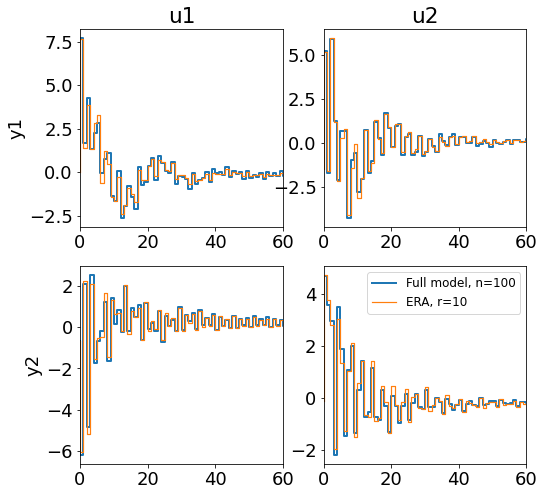

In [9]:
## Plot impulse responses for all methods

y1 = np.zeros((200,p,q))
y2 = np.zeros((100,p,q))
y3 = np.zeros((100,p,q))

for qi in range(q):
    y1[:,:,qi],t1 = impulse(sysFull,np.arange(200),input=qi)
    y2[:,:,qi],t2 = impulse(sysERA,np.arange(100),input=qi)
    y3[:,:,qi],t3 = impulse(sysERAOKID,np.arange(100),input=qi)

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[0].step(t1,y1[:,0,0],linewidth=2)
axs[0].step(t2,y2[:,0,0],linewidth=1.2)
# axs[0].step(t3,y3[:,0,0],linewidth=1)
axs[0].set_ylabel('y1')
axs[0].set_title('u1')

axs[1].step(t1,y1[:,0,1],linewidth=2)
axs[1].step(t2,y2[:,0,1],linewidth=1.2)
# axs[1].step(t3,y3[:,0,1],linewidth=1)
axs[1].set_title('u2')

axs[2].step(t1,y1[:,1,0],linewidth=2)
axs[2].step(t2,y2[:,1,0],linewidth=1.2)
# axs[2].step(t3,y3[:,1,0],linewidth=1)
axs[2].set_ylabel('y2')

axs[3].step(t1,y1[:,1,1],linewidth=2,label='Full model, n=100')
axs[3].step(t2,y2[:,1,1],linewidth=1.2,label='ERA, r={}'.format(r))
# axs[3].step(t3,y3[:,1,1],linewidth=1,label='ERA/OKID, r={}'.format(r))
axs[3].legend(prop={'size': 12})

for ax in axs:
    ax.set_xlim(0,60)

plt.show()

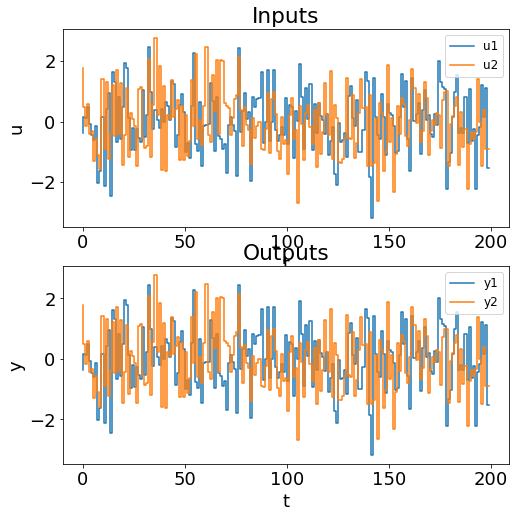

In [10]:
## Plot input/output pair for OKID
fig,axs = plt.subplots(2)

axs[0].set_title('Inputs')
axs[0].step(range(uRandom.shape[1]),uRandom[0,:],label='u1')
axs[0].step(range(uRandom.shape[1]),uRandom[1,:],label='u2')
axs[0].set_xlabel('t')
axs[0].set_ylabel('u')

axs[1].set_title('Outputs')
axs[1].step(range(yRandom.shape[1]),uRandom[0,:],label='y1')
axs[1].step(range(yRandom.shape[1]),uRandom[1,:],label='y2')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

for ax in axs:
    ax.legend(prop={'size': 12})


plt.show()